In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import matthews_corrcoef
from sklearn.feature_selection import chi2
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import AdaBoostClassifier
from nltk.tokenize import word_tokenize
import numpy as np
!pip install gensim
from gensim.models import Word2Vec

## Load Dataset

In [2]:
df = pd.read_csv("lemmatized_synonym_augment_train.csv")
df_test = pd.read_csv("lemmatized_original_test.csv")
print(len(df))
print(len(df_test))

8162
1341


In [3]:
df

,Unnamed: 0,Unnamed: 0.1,text,sentiment,lemmatized and stopwords_removed
0,0,0,should uber use driverless cars to ease safety...,0,uber use driverless car ease safety concern
1,1,1,oh hai minorityreport is making your driverles...,0,oh hai minorityreport driverless transportatio...
2,2,2,who is responsible if a self driving car gets ...,0,responsible self drive car accident
3,3,3,i almost got rear ended by the google car iron...,-1,got rear end google car ironic
4,4,4,self driving cars will be a hit until the firs...,-1,self drive car hit family hit algorithm sue
...,...,...,...,...,...
8157,8157,1299,cannot help but harmonize him the user experie...,-1,help harmonize user experience thermostat self...
8158,8158,1300,cant wait for self driving car to experiment o...,-1,nt wait self drive car experiment emotion
8159,8159,1301,cant time lag for self driving cars to experim...,-1,nt time lag self drive car experiment emotion
8160,8160,1302,the lonesome benefit for a self drive car woul...,-1,lonesome benefit self drive car comprise inebr...


In [4]:
df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'], inplace=True)
df_test.drop(columns=['Unnamed: 0'], inplace=True)

In [5]:
X_train = df['lemmatized and stopwords_removed']
y_train = df['sentiment']
X_test = df_test['lemmatized and stopwords_removed']
y_test = df_test['sentiment']

## Generating n-grams

In [6]:
# TfidfVectorizer (Unigram)  
corpus = X_train

vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1, 1), token_pattern=u"(?u)\\b\\w+\\b", min_df=10)

train_counts_unigram = vectorizer.fit_transform(corpus)
test_counts_unigram = vectorizer.transform(X_test)

# initialize vectorized text dataframe
df_vectorized_text_unigrams_train = pd.DataFrame(data=train_counts_unigram.toarray(), columns=vectorizer.get_feature_names())
df_vectorized_text_unigrams_test = pd.DataFrame(data=test_counts_unigram.toarray(), columns=vectorizer.get_feature_names())

################################################################

# TfidfVectorizer (Unigram & Bigram)  
corpus = X_train

vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), token_pattern=u"(?u)\\b\\w+\\b", min_df=10)

train_counts_unigram_and_bigram = vectorizer.fit_transform(corpus)
test_counts_unigram_and_bigram = vectorizer.transform(X_test)

# initialize vectorized text dataframe
df_vectorized_text_unigrams_and_bigrams_train = pd.DataFrame(data=train_counts_unigram_and_bigram.toarray(), columns=vectorizer.get_feature_names())
df_vectorized_text_unigrams_and_bigrams_test = pd.DataFrame(data=test_counts_unigram_and_bigram.toarray(), columns=vectorizer.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Baseline (Unigrams) Results

## Training without Chi Square Feature Selection

In [8]:
X_train = df_vectorized_text_unigrams_train
X_test = df_vectorized_text_unigrams_test

clf = AdaBoostClassifier(random_state=0).fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
print('Train Accuracy: ' + '{:.2%}'.format(accuracy_score(y_train, y_train_pred)))

y_test_pred = clf.predict(X_test)
print('Test Accuracy: ' + '{:.2%}'.format(accuracy_score(y_test, y_test_pred)))
print('Test F1 Score: ' + '{:.2%}'.format(f1_score(y_test, y_test_pred, average='weighted')))

## Cross Validation
cross_val_accuracy_scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=10, n_jobs=-1)   
print("Mean Cross Val Accuracy: " + '{:.2%}'.format(cross_val_accuracy_scores.mean()))
    
cross_val_f1_scores = cross_val_score(clf, X_train, y_train, scoring='f1_weighted', cv=10, n_jobs=-1)
print("Mean Cross Val F1 Score: " + '{:.2%}'.format(cross_val_f1_scores.mean()))

testing_matthew_coeff = matthews_corrcoef(y_test, y_test_pred)
print("Testing Matthew's coefficient:", round(testing_matthew_coeff,3))

Train Accuracy: 58.21%
Test Accuracy: 67.41%
Test F1 Score: 64.29%
Mean Cross Val Accuracy: 55.91%
Mean Cross Val F1 Score: 52.85%
Testing Matthew's coefficient: 0.318


## Training with Chi Square Feature Selection

In [7]:
# 0 is chi2 score, 1 is p-value
X_train = df_vectorized_text_unigrams_train
X_test = df_vectorized_text_unigrams_test

chi2_values = chi2(X_train.values, y_train)
chi2_df = pd.DataFrame(data=chi2_values, columns=X_train.columns)
chi2_df_sorted = chi2_df.sort_values(by=0, axis = 1, ascending = False)
chi2_df_sorted

,cool,ego,wait,awesome,non,want,amazing,trust,fbi,love,job,concern,major,wow,problem,flaw,information,creepy,point,organization,scare,motorcar,forward,excited,worry,railroad,railway,weapon,elevator,pretty,vehicle,surveillance,cable,google,ugly,gondola,lazy,wtf,need,toyota,...,explain,tell,accept,century,cyclist,ok,carry,nearly,sell,house,microsoft,rider,fully,eye,cross,merge,large,rest,steve,silly,add,track,article,easy,heaven,low,friendly,goal,practical,door,driving,promise,student,look,social,minute,state,help,free,likely
0,8.898436e+01,8.311288e+01,5.375322e+01,4.738221e+01,4.724773e+01,4.492799e+01,3.649875e+01,3.384646e+01,3.304004e+01,3.176074e+01,3.004119e+01,2.966253e+01,2.900453e+01,26.030322,25.684598,25.624664,25.390019,25.381964,25.307818,23.860683,23.647720,23.508877,23.425798,23.259951,22.958009,21.763490,21.751730,21.730967,21.590606,21.498797,21.084355,20.815268,20.783167,20.742790,20.529650,20.126460,19.097214,18.924964,18.86300,18.335391,...,0.179828,0.156517,0.153777,0.150861,0.146001,0.142523,0.134987,0.134562,0.133741,0.132227,0.130564,0.126754,0.126176,0.123529,0.123172,0.115293,0.114041,0.107131,0.102747,0.087794,0.071697,0.063823,0.060428,0.059043,0.057103,0.056628,0.055913,0.050741,0.046032,0.041960,0.030157,0.028368,0.026241,0.023105,0.020919,0.019089,0.015443,0.015427,0.006830,0.004438
1,4.756558e-20,8.959167e-19,2.126364e-12,5.141441e-11,5.499023e-11,1.753929e-10,1.186856e-08,4.470275e-08,6.690322e-08,1.268362e-07,2.996666e-07,3.621291e-07,5.032054e-07,0.000002,0.000003,0.000003,0.000003,0.000003,0.000003,0.000007,0.000007,0.000008,0.000008,0.000009,0.000010,0.000019,0.000019,0.000019,0.000020,0.000021,0.000026,0.000030,0.000031,0.000031,0.000035,0.000043,0.000071,0.000078,0.00008,0.000104,...,0.914010,0.924725,0.925993,0.927344,0.929600,0.931218,0.934734,0.934932,0.935316,0.936024,0.936803,0.938589,0.938861,0.940104,0.940272,0.943983,0.944575,0.947844,0.949924,0.957052,0.964786,0.968592,0.970238,0.970910,0.971852,0.972083,0.972430,0.974949,0.977247,0.979239,0.985035,0.985916,0.986965,0.988514,0.989595,0.990501,0.992308,0.992316,0.996591,0.997783


## Finding the optimal number of features to use based on cross validation F1-score

In [8]:
f1_results_unigram_chi_square = {}
for n in range(1, 965, 5):
    chi2_columns_unigrams = chi2_df_sorted.columns[:n]
    X_train_df = df_vectorized_text_unigrams_train[chi2_columns_unigrams]

    #train MLR
    clf = AdaBoostClassifier(random_state=0)

    #Cross validation, cv=5
    f1 = cross_val_score(clf, X_train_df, y_train, scoring='f1_weighted', cv=5)
    
    #Storing mean cross validation F1-scores in a dictionary
    f1_results_unigram_chi_square[n] = f1.mean() 

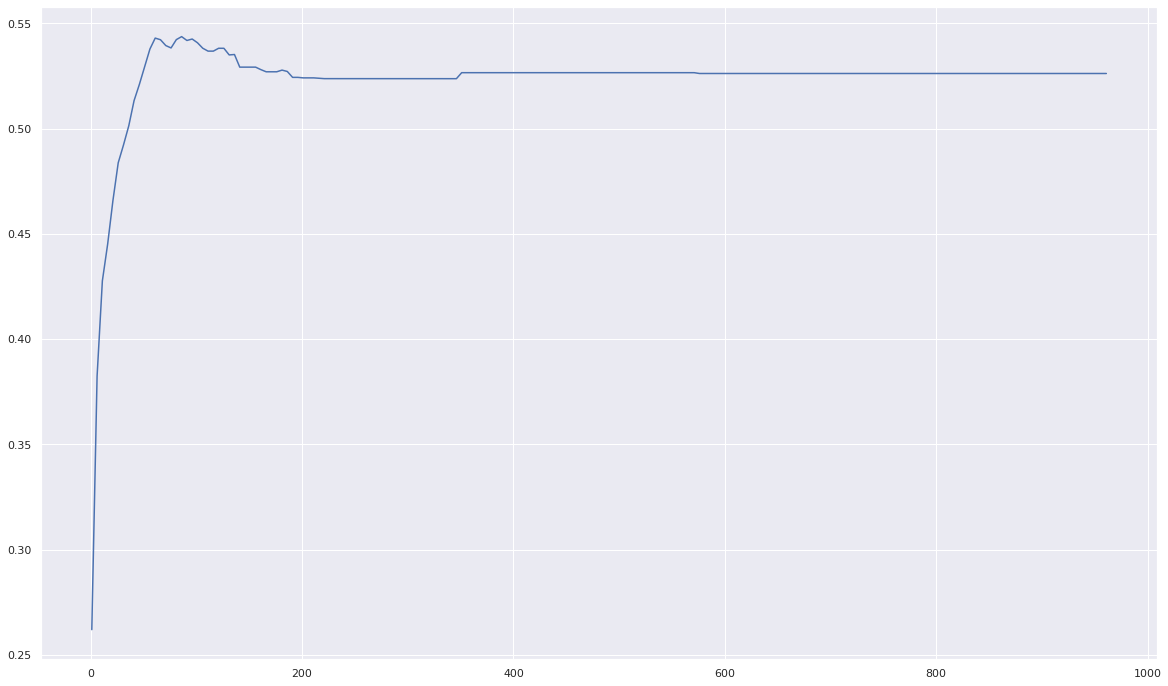

In [9]:
sns.set(rc={'figure.figsize':(20,12)})
sns.lineplot(data=f1_results_unigram_chi_square)

In [10]:
# Getting the optimal number of features which will result in best mean cross validation F1-score from the dictionary

best_no_of_features= max(f1_results_unigram_chi_square, key=f1_results_unigram_chi_square.get)
best_no_of_features

86

In [11]:
# Extracting the optimal number of features into a dataframe for training

chi2_columns = chi2_df_sorted.columns[:best_no_of_features]
X_train_vectorized_unigrams_chi_square = df_vectorized_text_unigrams_train[chi2_columns]
X_test_vectorized_unigrams_chi_square = df_vectorized_text_unigrams_test[chi2_columns]

In [12]:
X_train = X_train_vectorized_unigrams_chi_square
X_test = X_test_vectorized_unigrams_chi_square

clf = AdaBoostClassifier(random_state=0).fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
print('Train Accuracy: ' + '{:.2%}'.format(accuracy_score(y_train, y_train_pred)))

y_test_pred = clf.predict(X_test)
print('Test Accuracy: ' + '{:.2%}'.format(accuracy_score(y_test, y_test_pred)))
print('Test F1 Score: ' + '{:.2%}'.format(f1_score(y_test, y_test_pred, average='weighted')))

## Cross Validation
cross_val_accuracy_scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=10, n_jobs=-1)   
print("Mean Cross Val Accuracy: " + '{:.2%}'.format(cross_val_accuracy_scores.mean()))
    
cross_val_f1_scores = cross_val_score(clf, X_train, y_train, scoring='f1_weighted', cv=10, n_jobs=-1)
print("Mean Cross Val F1 Score: " + '{:.2%}'.format(cross_val_f1_scores.mean()))

testing_matthew_coeff = matthews_corrcoef(y_test, y_test_pred)
print("Testing Matthew's coefficient:", round(testing_matthew_coeff,3))

Train Accuracy: 58.93%
Test Accuracy: 67.56%
Test F1 Score: 64.24%
Mean Cross Val Accuracy: 57.69%
Mean Cross Val F1 Score: 54.74%
Testing Matthew's coefficient: 0.319


## Unigrams + Bigrams Results

## Training without Chi Square Feature Selection

In [13]:
X_train = df_vectorized_text_unigrams_and_bigrams_train
X_test = df_vectorized_text_unigrams_and_bigrams_test

clf = AdaBoostClassifier(random_state=0).fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
print('Train Accuracy: ' + '{:.2%}'.format(accuracy_score(y_train, y_train_pred)))

y_test_pred = clf.predict(X_test)
print('Test Accuracy: ' + '{:.2%}'.format(accuracy_score(y_test, y_test_pred)))
print('Test F1 Score: ' + '{:.2%}'.format(f1_score(y_test, y_test_pred, average='weighted')))

## Cross Validation
cross_val_accuracy_scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=10, n_jobs=-1)   
print("Mean Cross Val Accuracy: " + '{:.2%}'.format(cross_val_accuracy_scores.mean()))
    
cross_val_f1_scores = cross_val_score(clf, X_train, y_train, scoring='f1_weighted', cv=10, n_jobs=-1)
print("Mean Cross Val F1 Score: " + '{:.2%}'.format(cross_val_f1_scores.mean()))

testing_matthew_coeff = matthews_corrcoef(y_test, y_test_pred)
print("Testing Matthew's coefficient:", round(testing_matthew_coeff,3))

Train Accuracy: 58.31%
Test Accuracy: 66.22%
Test F1 Score: 63.06%
Mean Cross Val Accuracy: 55.49%
Mean Cross Val F1 Score: 52.54%
Testing Matthew's coefficient: 0.292


## Training with Chi Square Feature Selection

In [14]:
# 0 is chi2 score, 1 is p-value
X_train = df_vectorized_text_unigrams_and_bigrams_train
X_test = df_vectorized_text_unigrams_and_bigrams_test

chi2_values = chi2(X_train.values, y_train)
chi2_df = pd.DataFrame(data=chi2_values, columns=X_train.columns)
chi2_df_sorted = chi2_df.sort_values(by=0, axis = 1, ascending = False)
chi2_df_sorted

,cool,ego,ego drive,wait,non,awesome,amazing,want,fbi,concern,love,trust,google car,major,wait self,job,point,flaw,creepy,information technology,wow,problem,google ego,information,excited,scare,motorcar,worry,organization,vehicle,ugly,forward,want self,lazy,weapon,car cool,elevator car,railway,railroad,toyota,...,silly,googles self,car lol,rest,pass self,nearly,ok,future car,driverless google,car design,easy,merge,car mainstream,goal,steve,look,article,microsoft,track,little,fully,low,add,car real,like self,door,social,use self,friendly,practical,state,today google,help,driving,free,student,minute,heaven,promise,likely
0,7.230800e+01,6.821965e+01,6.229648e+01,4.205496e+01,4.151858e+01,3.764306e+01,3.170320e+01,2.921521e+01,27.351433,27.105606,26.996153,26.962168,25.712454,24.895669,24.669007,24.203575,22.787711,22.336676,21.611122,21.581792,21.485290,21.354559,20.965195,20.894105,20.84776,20.822774,20.390840,19.869957,19.523085,18.935603,18.856519,18.676447,18.408220,18.128683,17.661426,17.564927,17.316736,17.183081,16.919989,16.513101,...,0.112632,0.105168,0.104664,0.099120,0.099037,0.097713,0.092836,0.091422,0.090524,0.089060,0.087536,0.074825,0.073379,0.072077,0.07113,0.069811,0.068311,0.067779,0.066341,0.066162,0.058642,0.057637,0.056440,0.044839,0.040734,0.036738,0.035755,0.034705,0.032339,0.025406,0.022606,0.021486,0.017964,0.016465,0.013025,0.01274,0.012722,0.007483,0.001328,0.001277
1,1.988461e-16,1.535648e-15,2.968188e-14,7.377035e-10,9.646174e-10,6.697496e-09,1.305382e-07,4.528957e-07,0.000001,0.000001,0.000001,0.000001,0.000003,0.000004,0.000004,0.000006,0.000011,0.000014,0.000020,0.000021,0.000022,0.000023,0.000028,0.000029,0.00003,0.000030,0.000037,0.000048,0.000058,0.000077,0.000080,0.000088,0.000101,0.000116,0.000146,0.000153,0.000174,0.000186,0.000212,0.000260,...,0.945240,0.948775,0.949014,0.951648,0.951688,0.952318,0.954643,0.955318,0.955747,0.956447,0.957176,0.963278,0.963975,0.964603,0.96506,0.965697,0.966421,0.966678,0.967374,0.967460,0.971105,0.971593,0.972175,0.977830,0.979839,0.981798,0.982281,0.982797,0.983960,0.987377,0.988760,0.989315,0.991058,0.991801,0.993509,0.99365,0.993659,0.996265,0.999336,0.999362


## Finding the optimal number of features to use based on cross validation F1-score

In [15]:
f1_results_unigram_bigram = {}
for n in range(1, 1350, 5):
    chi2_columns_unigram_bigram = chi2_df_sorted.columns[:n]
    X_train_df = df_vectorized_text_unigrams_and_bigrams_train[chi2_columns_unigram_bigram]

    #train MLR
    clf = AdaBoostClassifier(random_state=0)

    #Cross validation, cv=5
    f1 = cross_val_score(clf, X_train_df, y_train, scoring='f1_weighted', cv=5)
    
    #Storing mean cross validation F1-scores in a dictionary
    f1_results_unigram_bigram[n] = f1.mean() 

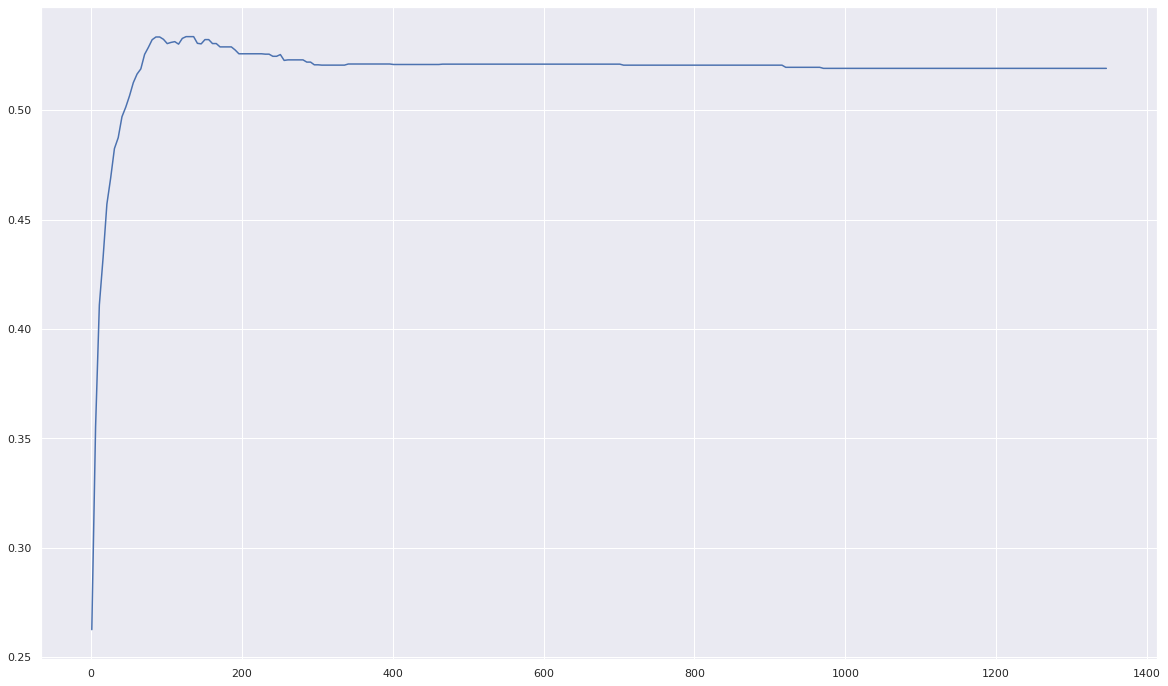

In [16]:
sns.set(rc={'figure.figsize':(20,12)})
sns.lineplot(data=f1_results_unigram_bigram)

In [17]:
# Getting the optimal number of features which will result in best mean cross validation F1-score from the dictionary

best_no_of_features= max(f1_results_unigram_bigram, key=f1_results_unigram_bigram.get)
best_no_of_features

126

In [18]:
# Extracting the optimal number of features into a dataframe for training

chi2_columns = chi2_df_sorted.columns[:best_no_of_features]
X_train_vectorized_unigram_bigram_chi_square = df_vectorized_text_unigrams_and_bigrams_train[chi2_columns]
X_test_vectorized_unigram_bigram_chi_square = df_vectorized_text_unigrams_and_bigrams_test[chi2_columns]

In [19]:
X_train = X_train_vectorized_unigram_bigram_chi_square
X_test = X_test_vectorized_unigram_bigram_chi_square

clf = AdaBoostClassifier(random_state=0).fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
print('Train Accuracy: ' + '{:.2%}'.format(accuracy_score(y_train, y_train_pred)))

y_test_pred = clf.predict(X_test)
print('Test Accuracy: ' + '{:.2%}'.format(accuracy_score(y_test, y_test_pred)))
print('Test F1 Score: ' + '{:.2%}'.format(f1_score(y_test, y_test_pred, average='weighted')))

## Cross Validation
cross_val_accuracy_scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=10, n_jobs=-1)   
print("Mean Cross Val Accuracy: " + '{:.2%}'.format(cross_val_accuracy_scores.mean()))
    
cross_val_f1_scores = cross_val_score(clf, X_train, y_train, scoring='f1_weighted', cv=10, n_jobs=-1)
print("Mean Cross Val F1 Score: " + '{:.2%}'.format(cross_val_f1_scores.mean()))

testing_matthew_coeff = matthews_corrcoef(y_test, y_test_pred)
print("Testing Matthew's coefficient:", round(testing_matthew_coeff,3))

Train Accuracy: 58.53%
Test Accuracy: 66.22%
Test F1 Score: 62.75%
Mean Cross Val Accuracy: 56.74%
Mean Cross Val F1 Score: 53.78%
Testing Matthew's coefficient: 0.288


## Unigrams + Bigrams + Unsupervised Topics Results

In [20]:
unsupervised_topics=[(1,
  [('google', 0.20161290322580644),
   ('street', 0.03938484621155289),
   ('city', 0.0277569392348087),
   ('state', 0.020255063765941484),
   ('watch', 0.019129782445611403),
   ('view', 0.018567141785446363),
   ('spot', 0.014816204051012753),
   ('map', 0.014441110277569393),
   ('truck', 0.01387846961740435),
   ('drone', 0.01312828207051763),
   ('fast', 0.009939984996249063),
   ('mountain', 0.008252063015753939),
   ('sound', 0.008252063015753939),
   ('lane', 0.007314328582145537),
   ('master', 0.007314328582145537),
   ('route', 0.006751687921980495),
   ('tree', 0.006751687921980495),
   ('deliver', 0.006564141035258815),
   ('lead', 0.006376594148537134),
   ('excited', 0.0061890472618154535),
   ('pine', 0.0061890472618154535),
   ('single', 0.0061890472618154535),
   ('computer', 0.0061890472618154535),
   ('wrong', 0.006001500375093774),
   ('study', 0.005813953488372093),
   ('passenger', 0.005438859714928732),
   ('datum', 0.005251312828207052),
   ('michigan', 0.005251312828207052),
   ('sense', 0.005063765941485371),
   ('university', 0.0046886721680420105)]),
 (2,
  [('google', 0.0676706061761342),
   ('wait', 0.035836828059473885),
   ('automobile', 0.019062142584826535),
   ('glass', 0.016965306900495615),
   ('safe', 0.016584064048799085),
   ('buy', 0.01639344262295082),
   ('happen', 0.015630956919557758),
   ('railway', 0.015440335493709493),
   ('talk', 0.015059092642012962),
   ('run', 0.0142966069386199),
   ('audi', 0.014105985512771636),
   ('stop', 0.01391536408692337),
   ('crash', 0.012581014105985514),
   ('park', 0.012199771254288982),
   ('parking', 0.011627906976744186),
   ('feel', 0.011437285550895921),
   ('innovation', 0.011246664125047654),
   ('point', 0.01105604269919939),
   ('place', 0.01067479984750286),
   ('lot', 0.010484178421654593),
   ('end', 0.010484178421654593),
   ('guy', 0.009531071292413268),
   ('highway', 0.009149828440716736),
   ('free', 0.008006099885627144),
   ('money', 0.007815478459778879),
   ('company', 0.007815478459778879),
   ('close', 0.007434235608082348),
   ('step', 0.0072436141822340835),
   ('week', 0.007052992756385818),
   ('yeah', 0.007052992756385818)]),
 (3,
  [('autonomous', 0.07629531220345416),
   ('vehicle', 0.06661605617764281),
   ('driving', 0.03093566141582843),
   ('taxi', 0.02239514139305371),
   ('love', 0.022015562725374836),
   ('trust', 0.016701461377870562),
   ('motorcar', 0.016132093376352248),
   ('number', 0.01480356803947618),
   ('job', 0.014044410704118429),
   ('ford', 0.011956728031884608),
   ('cable', 0.011956728031884608),
   ('bring', 0.009869045359650788),
   ('control', 0.00948946669197191),
   ('mt', 0.00948946669197191),
   ('electric', 0.008920098690453597),
   ('leave', 0.008350730688935281),
   ('atomic', 0.007781362687416967),
   ('forward', 0.007591573353577529),
   ('phone', 0.007211994685898652),
   ('safety', 0.007211994685898652),
   ('drivingcar', 0.007211994685898652),
   ('research', 0.0064528373505409),
   ('set', 0.0064528373505409),
   ('automate', 0.0064528373505409),
   ('pick', 0.006073258682862023),
   ('power', 0.006073258682862023),
   ('hurry', 0.005883469349022585),
   ('nice', 0.005883469349022585),
   ('motor', 0.005883469349022585),
   ('potential', 0.005503890681343709)]),
 (4,
  [('ego', 0.07308207384733116),
   ('thing', 0.030801607040367322),
   ('live', 0.016835660991008226),
   ('start', 0.014157260378802373),
   ('apple', 0.014157260378802373),
   ('pretty', 0.013583317390472546),
   ('transportation', 0.013392003061029271),
   ('home', 0.01300937440214272),
   ('railcar', 0.012818060072699445),
   ('design', 0.012818060072699445),
   ('interesting', 0.01262674574325617),
   ('turn', 0.01224411708436962),
   ('wow', 0.012052802754926343),
   ('train', 0.011096231107709967),
   ('big', 0.010904916778266693),
   ('smart', 0.008609144824947389),
   ('question', 0.008417830495504113),
   ('fbi', 0.008035201836617562),
   ('bus', 0.007652573177731012),
   ('head', 0.007652573177731012),
   ('force', 0.007461258848287737),
   ('iodin', 0.007461258848287737),
   ('share', 0.007269944518844462),
   ('science', 0.00650468720107136),
   ('worry', 0.00650468720107136),
   ('finally', 0.006313372871628085),
   ('mainstream', 0.00612205854218481),
   ('house', 0.00612205854218481),
   ('report', 0.00612205854218481),
   ('die', 0.00612205854218481)]),
 (5,
  [('future', 0.06766340808894),
   ('road', 0.05673758865248227),
   ('nt', 0.035077630822311676),
   ('ride', 0.03105232892466935),
   ('year', 0.0272187080697719),
   ('great', 0.02568525972781292),
   ('ready', 0.021659957830170596),
   ('pass', 0.021084914701935978),
   ('traffic', 0.019551466359977),
   ('law', 0.010350776308223116),
   ('video', 0.0097757331799885),
   ('pic', 0.009009009009009009),
   ('service', 0.008817327966264136),
   ('sign', 0.008050603795284647),
   ('sleep', 0.0070921985815602835),
   ('bill', 0.006900517538815411),
   ('pay', 0.006708836496070539),
   ('experience', 0.006708836496070539),
   ('light', 0.006133793367835921),
   ('ceo', 0.005750431282346176),
   ('true', 0.005750431282346176),
   ('infrastructure', 0.005750431282346176),
   ('stuff', 0.0055587502396013035),
   ('cruise', 0.0055587502396013035),
   ('camera', 0.005367069196856431),
   ('office', 0.005175388154111558),
   ('invest', 0.005175388154111558),
   ('maine', 0.005175388154111558),
   ('commute', 0.0047920260686218135),
   ('agree', 0.0047920260686218135)]),
 (6,
  [('cool', 0.03692707366858415),
   ('people', 0.035071441825941733),
   ('world', 0.02709222490257933),
   ('human', 0.0265355353497866),
   ('accident', 0.024679903507144184),
   ('day', 0.020226387084802375),
   ('machine', 0.017442939320838746),
   ('life', 0.017257376136574503),
   ('idea', 0.016886249768046018),
   ('hit', 0.0150306179254036),
   ('elevator', 0.01410280200408239),
   ('hope', 0.013917238819818148),
   ('insurance', 0.013731675635553907),
   ('railroad', 0.013546112451289664),
   ('change', 0.012989422898496939),
   ('mile', 0.012803859714232696),
   ('real', 0.01224717016143997),
   ('push', 0.010391538318797551),
   ('fly', 0.010391538318797551),
   ('exist', 0.010020411950269066),
   ('kill', 0.009649285581740583),
   ('save', 0.00946372239747634),
   ('googles', 0.009278159213212098),
   ('dream', 0.008907032844683615),
   ('hour', 0.008721469660419373),
   ('cost', 0.007979216923362405),
   ('complete', 0.007793653739098163),
   ('man', 0.007793653739098163),
   ('invent', 0.007422527370569679),
   ('drunk', 0.007236964186305437)]),
 (7,
  [('google', 0.06018168054504164),
   ('california', 0.03785011355034065),
   ('work', 0.0350113550340651),
   ('good', 0.031037093111279335),
   ('test', 0.029901589704769114),
   ('auto', 0.029523088569265707),
   ('legal', 0.015518546555639667),
   ('follow', 0.013436790310370931),
   ('bad', 0.012869038607115822),
   ('gondola', 0.012869038607115822),
   ('find', 0.011544284632853898),
   ('news', 0.010219530658591975),
   ('require', 0.010030280090840272),
   ('project', 0.009651778955336867),
   ('toyota', 0.008894776684330053),
   ('legalize', 0.008327024981074944),
   ('lexus', 0.008327024981074944),
   ('market', 0.008327024981074944),
   ('government', 0.00813777441332324),
   ('license', 0.00813777441332324),
   ('testing', 0.007948523845571537),
   ('issue', 0.00757002271006813),
   ('omg', 0.007191521574564724),
   ('permit', 0.007191521574564724),
   ('hey', 0.007191521574564724),
   ('worth', 0.007002271006813021),
   ('totally', 0.006813020439061317),
   ('goog', 0.006813020439061317),
   ('picture', 0.006434519303557911),
   ('hold', 0.006245268735806208)]),
 (8,
  [('technology', 0.053527520332892),
   ('uber', 0.0414223567240401),
   ('time', 0.0346132021940609),
   ('tech', 0.027047474938528465),
   ('robot', 0.024399470399092113),
   ('information', 0.023075468129373937),
   ('build', 0.022508038585209004),
   ('problem', 0.018346888594666162),
   ('tesla', 0.016455456780783053),
   ('public', 0.01418573860412332),
   ('long', 0.013240022697181766),
   ('read', 0.011348590883298657),
   ('nissan', 0.010592018157745414),
   ('plan', 0.01002458861358048),
   ('break', 0.009268015888027236),
   ('fleet', 0.009078872706638926),
   ('morning', 0.009078872706638926),
   ('develop', 0.008889729525250615),
   ('create', 0.008511443162473993),
   ('astir', 0.008322299981085681),
   ('valley', 0.008133156799697372),
   ('transit', 0.0075657272555324385),
   ('solve', 0.007376584074144127),
   ('article', 0.007376584074144127),
   ('silicon', 0.007187440892755816),
   ('launch', 0.006809154529979195),
   ('major', 0.006430868167202572),
   ('detroit', 0.0062417249858142615),
   ('sf', 0.006052581804425951),
   ('model', 0.005863438623037639)]),
 (9,
  [('google', 0.28367997002061085),
   ('today', 0.034663668727749675),
   ('wheel', 0.03372681281618887),
   ('steering', 0.021922428330522766),
   ('awesome', 0.015364436949597151),
   ('prototype', 0.012741240397226907),
   ('unveil', 0.011991755667978264),
   ('amazing', 0.011804384485666104),
   ('hand', 0.011617013303353943),
   ('brake', 0.0099306726625445),
   ('fun', 0.009743301480232341),
   ('speed', 0.009743301480232341),
   ('shit', 0.00936855911560802),
   ('pedal', 0.008056960839422896),
   ('roll', 0.008056960839422896),
   ('googleplex', 0.007869589657110737),
   ('check', 0.007682218474798576),
   ('fuck', 0.007494847292486416),
   ('program', 0.007494847292486416),
   ('limit', 0.006745362563237774),
   ('cute', 0.006745362563237774),
   ('announce', 0.006183249016301293),
   ('codecon', 0.006183249016301293),
   ('bmw', 0.005246393104740491),
   ('freak', 0.0048716507401161705),
   ('win', 0.0048716507401161705),
   ('meet', 0.00468427955780401),
   ('kid', 0.00468427955780401),
   ('face', 0.00468427955780401),
   ('post', 0.004122166010867528)])]

df_train_unsupervised_unigram_bigram=df.copy()
df_test_unsupervised_unigram_bigram=df_test.copy()

def assign_topic_score(text, topic_no):
    topic_list=unsupervised_topics[topic_no-1][1]    
    
    wordlist=text.split(' ')
    topic_score=0
    for word in wordlist:
        for word_weight in topic_list:
            if word==word_weight[0]:
                topic_score+=word_weight[1]
                
    return topic_score
    
for each_topic in unsupervised_topics:
    df_train_unsupervised_unigram_bigram['unsupervised_topic_' + str(each_topic[0])]= df_train_unsupervised_unigram_bigram.apply(lambda row: assign_topic_score(row['lemmatized and stopwords_removed'], each_topic[0]), axis=1)
    df_test_unsupervised_unigram_bigram['unsupervised_topic_' + str(each_topic[0])]= df_test_unsupervised_unigram_bigram.apply(lambda row: assign_topic_score(row['lemmatized and stopwords_removed'], each_topic[0]), axis=1)

## Training without Chi Square Feature Selection

## Preparing data for model training

In [21]:
# Scaling the Unsupervised topics

scaler = MinMaxScaler()
scaled_train_unsupervised_unigram_bigram = scaler.fit_transform(df_train_unsupervised_unigram_bigram.iloc[:, 3:])
scaled_test_unsupervised_unigram_bigram = scaler.transform(df_test_unsupervised_unigram_bigram.iloc[:, 3:])

# Transforming scaled topics into a dataframe

scaled_train_unsupervised_unigram_bigram_df = pd.DataFrame(scaled_train_unsupervised_unigram_bigram, columns = df_train_unsupervised_unigram_bigram.iloc[:, 3:].columns)
scaled_test_unsupervised_unigram_bigram_df = pd.DataFrame(scaled_test_unsupervised_unigram_bigram, columns = df_test_unsupervised_unigram_bigram.iloc[:, 3:].columns)

# Combining Unigrams + Bigrams + Unsupervised topics into one dataframe

train_unsupervised_unigram_bigram = pd.concat([scaled_train_unsupervised_unigram_bigram_df, df_vectorized_text_unigrams_and_bigrams_train], axis=1)
test_unsupervised_unigram_bigram = pd.concat([scaled_test_unsupervised_unigram_bigram_df, df_vectorized_text_unigrams_and_bigrams_test], axis=1)

In [22]:
X_train = train_unsupervised_unigram_bigram
X_test = test_unsupervised_unigram_bigram

clf = AdaBoostClassifier(random_state=0).fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
print('Train Accuracy: ' + '{:.2%}'.format(accuracy_score(y_train, y_train_pred)))

y_test_pred = clf.predict(X_test)
print('Test Accuracy: ' + '{:.2%}'.format(accuracy_score(y_test, y_test_pred)))
print('Test F1 Score: ' + '{:.2%}'.format(f1_score(y_test, y_test_pred, average='weighted')))

## Cross Validation
cross_val_accuracy_scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=10, n_jobs=-1)   
print("Mean Cross Val Accuracy: " + '{:.2%}'.format(cross_val_accuracy_scores.mean()))
    
cross_val_f1_scores = cross_val_score(clf, X_train, y_train, scoring='f1_weighted', cv=10, n_jobs=-1)
print("Mean Cross Val F1 Score: " + '{:.2%}'.format(cross_val_f1_scores.mean()))

testing_matthew_coeff = matthews_corrcoef(y_test, y_test_pred)
print("Testing Matthew's coefficient:", round(testing_matthew_coeff,3))

Train Accuracy: 58.52%
Test Accuracy: 65.47%
Test F1 Score: 62.90%
Mean Cross Val Accuracy: 56.16%
Mean Cross Val F1 Score: 53.85%
Testing Matthew's coefficient: 0.284


## Training with Chi Square Feature Selection

## Preparing data for model training

In [23]:
# Scaling the Unsupervised topics

scaler = MinMaxScaler()
scaled_train_unsupervised_unigram_bigram_chi_square = scaler.fit_transform(df_train_unsupervised_unigram_bigram.iloc[:, 3:])
scaled_test_unsupervised_unigram_bigram_chi_square = scaler.transform(df_test_unsupervised_unigram_bigram.iloc[:, 3:])

# Transforming scaled topics into a dataframe

scaled_train_unsupervised_unigram_bigram_chi_square_df = pd.DataFrame(scaled_train_unsupervised_unigram_bigram_chi_square, columns = df_train_unsupervised_unigram_bigram.iloc[:, 3:].columns)
scaled_test_unsupervised_unigram_bigram_chi_square_df = pd.DataFrame(scaled_test_unsupervised_unigram_bigram_chi_square, columns = df_test_unsupervised_unigram_bigram.iloc[:, 3:].columns)

# Combining Unigrams + Bigrams + Unsupervised topics into one dataframe

train_unsupervised_unigram_bigram_chi_square_df = pd.concat([scaled_train_unsupervised_unigram_bigram_chi_square_df, df_vectorized_text_unigrams_and_bigrams_train], axis=1)
test_unsupervised_unigram_bigram_chi_square_df = pd.concat([scaled_test_unsupervised_unigram_bigram_chi_square_df, df_vectorized_text_unigrams_and_bigrams_test], axis=1)

In [24]:
# 0 is chi2 score, 1 is p-value
X_train = train_unsupervised_unigram_bigram_chi_square_df
X_test = test_unsupervised_unigram_bigram_chi_square_df

chi2_values = chi2(X_train.values, y_train)
chi2_df = pd.DataFrame(data=chi2_values, columns=X_train.columns)
chi2_df_sorted = chi2_df.sort_values(by=0, axis = 1, ascending = False)
chi2_df_sorted

,unsupervised_topic_4,cool,ego,ego drive,unsupervised_topic_6,wait,non,awesome,amazing,want,fbi,concern,love,trust,google car,major,wait self,job,point,flaw,creepy,information technology,wow,problem,google ego,information,excited,scare,motorcar,worry,organization,vehicle,ugly,forward,want self,lazy,weapon,car cool,elevator car,railway,...,silly,googles self,car lol,rest,pass self,nearly,ok,future car,driverless google,car design,easy,merge,car mainstream,goal,steve,look,article,microsoft,track,little,fully,low,add,car real,like self,door,social,use self,friendly,practical,state,today google,help,driving,free,student,minute,heaven,promise,likely
0,1.006229e+02,7.230800e+01,6.821965e+01,6.229648e+01,4.632336e+01,4.205496e+01,4.151858e+01,3.764306e+01,3.170320e+01,2.921521e+01,27.351433,27.105606,26.996153,26.962168,25.712454,24.895669,24.669007,24.203575,22.787711,22.336676,21.611122,21.581792,21.485290,21.354559,20.965195,20.894105,20.84776,20.822774,20.390840,19.869957,19.523085,18.935603,18.856519,18.676447,18.408220,18.128683,17.661426,17.564927,17.316736,17.183081,...,0.112632,0.105168,0.104664,0.099120,0.099037,0.097713,0.092836,0.091422,0.090524,0.089060,0.087536,0.074825,0.073379,0.072077,0.07113,0.069811,0.068311,0.067779,0.066341,0.066162,0.058642,0.057637,0.056440,0.044839,0.040734,0.036738,0.035755,0.034705,0.032339,0.025406,0.022606,0.021486,0.017964,0.016465,0.013025,0.01274,0.012722,0.007483,0.001328,0.001277
1,1.412590e-22,1.988461e-16,1.535648e-15,2.968188e-14,8.729930e-11,7.377035e-10,9.646174e-10,6.697496e-09,1.305382e-07,4.528957e-07,0.000001,0.000001,0.000001,0.000001,0.000003,0.000004,0.000004,0.000006,0.000011,0.000014,0.000020,0.000021,0.000022,0.000023,0.000028,0.000029,0.00003,0.000030,0.000037,0.000048,0.000058,0.000077,0.000080,0.000088,0.000101,0.000116,0.000146,0.000153,0.000174,0.000186,...,0.945240,0.948775,0.949014,0.951648,0.951688,0.952318,0.954643,0.955318,0.955747,0.956447,0.957176,0.963278,0.963975,0.964603,0.96506,0.965697,0.966421,0.966678,0.967374,0.967460,0.971105,0.971593,0.972175,0.977830,0.979839,0.981798,0.982281,0.982797,0.983960,0.987377,0.988760,0.989315,0.991058,0.991801,0.993509,0.99365,0.993659,0.996265,0.999336,0.999362


## Finding the optimal number of features to use based on cross validation F1-score

In [25]:
f1_results_unsupervised_unigram_bigram_chi_square = {}
for n in range(1, 1359, 5):
    chi2_columns_unsupervised_unigram_bigram = chi2_df_sorted.columns[:n]
    X_train_df = train_unsupervised_unigram_bigram_chi_square_df[chi2_columns_unsupervised_unigram_bigram]

    #train MLR
    clf = AdaBoostClassifier(random_state=0)

    #Cross validation, cv=5
    f1 = cross_val_score(clf, X_train_df, y_train, scoring='f1_weighted', cv=5)
    
    #Storing mean cross validation F1-scores in a dictionary
    f1_results_unsupervised_unigram_bigram_chi_square[n] = f1.mean() 

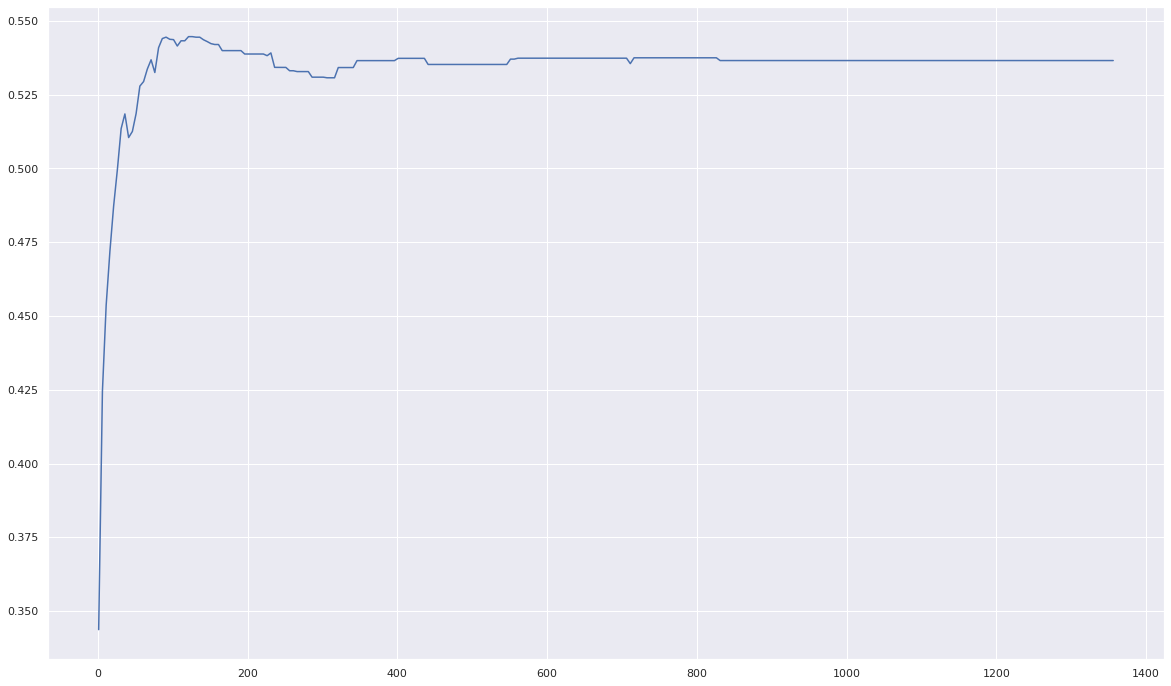

In [26]:
sns.set(rc={'figure.figsize':(20,12)})
sns.lineplot(data=f1_results_unsupervised_unigram_bigram_chi_square)

In [27]:
# Getting the optimal number of features which will result in best mean cross validation F1-score from the dictionary

best_no_of_features= max(f1_results_unsupervised_unigram_bigram_chi_square, key=f1_results_unsupervised_unigram_bigram_chi_square.get)
best_no_of_features

121

In [28]:
# Extracting the optimal number of features into a dataframe for training

chi2_columns = chi2_df_sorted.columns[:best_no_of_features]
scaled_train_unsupervised_unigram_bigram_df_chi_square = train_unsupervised_unigram_bigram_chi_square_df[chi2_columns]
scaled_test_unsupervised_unigram_bigram_df_chi_square = test_unsupervised_unigram_bigram_chi_square_df[chi2_columns]

In [29]:
X_train = scaled_train_unsupervised_unigram_bigram_df_chi_square
X_test = scaled_test_unsupervised_unigram_bigram_df_chi_square

clf = AdaBoostClassifier(random_state=0).fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
print('Train Accuracy: ' + '{:.2%}'.format(accuracy_score(y_train, y_train_pred)))

y_test_pred = clf.predict(X_test)
print('Test Accuracy: ' + '{:.2%}'.format(accuracy_score(y_test, y_test_pred)))
print('Test F1 Score: ' + '{:.2%}'.format(f1_score(y_test, y_test_pred, average='weighted')))

## Cross Validation
cross_val_accuracy_scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=10, n_jobs=-1)   
print("Mean Cross Val Accuracy: " + '{:.2%}'.format(cross_val_accuracy_scores.mean()))
    
cross_val_f1_scores = cross_val_score(clf, X_train, y_train, scoring='f1_weighted', cv=10, n_jobs=-1)
print("Mean Cross Val F1 Score: " + '{:.2%}'.format(cross_val_f1_scores.mean()))

testing_matthew_coeff = matthews_corrcoef(y_test, y_test_pred)
print("Testing Matthew's coefficient:", round(testing_matthew_coeff,3))

Train Accuracy: 59.26%
Test Accuracy: 64.88%
Test F1 Score: 62.33%
Mean Cross Val Accuracy: 56.62%
Mean Cross Val F1 Score: 54.30%
Testing Matthew's coefficient: 0.274


## Unigrams + Bigrams + Supervised topics

In [30]:
# These topics are generated manually by observing highest frequency words.

def accident(text):
    wordlist=['die', 'death', 'kill', 'hit', 'crash', 'accident', 'insurance', 'drunk', 'drink', 'safety', 'speed', 'limit']
    words=text.split(' ')
    for word in words:
        if word in wordlist:
            return 1
    return 0

def change(text):
    wordlist=['change', 'replace', 'become', 'happen', 'transform']
    words=text.split(' ')
    for word in words:
        if word in wordlist:
            return 1
    return 0

def imagination_vs_reality(text):
    wordlist= ['reality', 'dream', 'imagine', 'imagination', 'challenge']
    words=text.split(' ')
    for word in words:
        if word in wordlist:
            return 1
    return 0

def law(text):
    wordlist=['policy', 'law', 'legal', 'government', 'state', 'regulation', 'license', 'approve', 'allow', 'rule', 
              'public']
    words=text.split(' ')
    for word in words:
        if word in wordlist:
            return 1
    return 0

def time(text):
    wordlist=['future', 'today', 'next', 'year', 'past', 'world']
    words=text.split(' ')
    for word in words:
        if word in wordlist:
            return 1
    return 0

def technology(text):
    wordlist=['technology', 'tech', 'robot', 'drone', 'machine', 'computer', 'robotic', 'program', 'ai', 'automobile', 
              'electric', 'system', 'information', 'data', 'automate']
    words=text.split(' ')
    for word in words:
        if word in wordlist:
            return 1
    return 0

def innovation(text):
    wordlist=['research', 'invent', 'innovation', 'innovate', 'invention', 'breakthrough', 'idea', 'develop', 
              'create', 'prototype', 'develop', 'build']
    words=text.split(' ')
    for word in words:
        if word in wordlist:
            return 1
    return 0

def business(text):
    wordlist=['money', 'invest', 'market', 'ceo', 'cost', 'buy', 'business', 'company']
    words=text.split(' ')
    for word in words:
        if word in wordlist:
            return 1
    return 0


def positive_words(text):
    wordlist=['get', 'want', 'cool', 'good', 'great', 'love', 'awesome', 'wow', 'perfect', 'solve', 'solution', 
              'excite', 'fun', 'safe', 'help', 'best', 'hope', 'lead']
              
    double_words=['look forward', 'cant wait']
    
    count=0
    words=text.split(' ')
    for word in words:
        if word in wordlist:
            count+=1
            wordlist.remove(word)
    
    for phrase in double_words:
        if phrase in text:
            count+=1
              
    return count
              
              

def bad_words(text):
    wordlist=['never', 'fuck', 'shit', 'hell', 'scary', 'wtf', 'freak', 'hate', 'wrong', 'worry', 'die', 
              'kill', 'bad', 'crazy', 'death', 'problem', 'dangerous']
    count=0
    words=text.split(' ')
    for word in words:
        if word in wordlist:
            count+=1
            wordlist.remove(word)
    
    return count


#brands/places/transportation type/events/products
columns=['toyota', 'audi', 'tesla', 'apple', 'google', 'uber', 'ford', 'lexus', 'nissan', 'volvo', 'bmw', 'california', 
         'michigan', 'detroit', 'googleplex', 'dmv', 'ce', 'codecon', 'forbes', 
         'cnet', 'wsj', 'train', 'railway', 'cruise', 'road', 'taxi', 'truck', 'highway', 'bus', 'cab', 'bike', 'freeway',
         'googlecar', 'camera', 'ego']

double_words=['ann arbor', 'silicon valley', 'google map', 'google glass']

def get_column_value(text, word):
    wordlist=text.split(' ')
    if word in wordlist:
        return 1
    return 0

def get_double_value(text, phrase):
    if phrase in text:
        return 1
    return 0

In [31]:
df_train_supervised_unigram_bigram=df.copy()
df_test_supervised_unigram_bigram=df_test.copy()

In [32]:
for word in columns:
    df_train_supervised_unigram_bigram['topic ' + word]=df_train_supervised_unigram_bigram.apply(lambda x: get_column_value(x['lemmatized and stopwords_removed'], word), axis=1)
    df_test_supervised_unigram_bigram['topic ' + word]=df_test_supervised_unigram_bigram.apply(lambda x: get_column_value(x['lemmatized and stopwords_removed'], word), axis=1)
for phrase in double_words:
    df_train_supervised_unigram_bigram['topic ' + phrase]=df_train_supervised_unigram_bigram.apply(lambda x: get_double_value(x['lemmatized and stopwords_removed'], phrase), axis=1)
    df_test_supervised_unigram_bigram['topic ' + phrase]=df_test_supervised_unigram_bigram.apply(lambda x: get_column_value(x['lemmatized and stopwords_removed'], word), axis=1)

In [33]:
# train dataset
df_train_supervised_unigram_bigram['topic accident']= df_train_supervised_unigram_bigram['lemmatized and stopwords_removed'].apply(accident)
df_train_supervised_unigram_bigram['topic change']= df_train_supervised_unigram_bigram['lemmatized and stopwords_removed'].apply(change)
df_train_supervised_unigram_bigram['topic imagination_vs_reality']= df_train_supervised_unigram_bigram['lemmatized and stopwords_removed'].apply(imagination_vs_reality)
df_train_supervised_unigram_bigram['topic law']= df_train_supervised_unigram_bigram['lemmatized and stopwords_removed'].apply(law)
df_train_supervised_unigram_bigram['topic time']= df_train_supervised_unigram_bigram['lemmatized and stopwords_removed'].apply(time)
df_train_supervised_unigram_bigram['topic technology']= df_train_supervised_unigram_bigram['lemmatized and stopwords_removed'].apply(technology)
df_train_supervised_unigram_bigram['topic innovation']= df_train_supervised_unigram_bigram['lemmatized and stopwords_removed'].apply(innovation)
df_train_supervised_unigram_bigram['topic business']= df_train_supervised_unigram_bigram['lemmatized and stopwords_removed'].apply(business)

df_train_supervised_unigram_bigram['topic positive_words']= df_train_supervised_unigram_bigram['lemmatized and stopwords_removed'].apply(positive_words)
df_train_supervised_unigram_bigram['topic bad_words']= df_train_supervised_unigram_bigram['lemmatized and stopwords_removed'].apply(bad_words)
df_train_supervised_unigram_bigram['topic net positive']=df_train_supervised_unigram_bigram['topic positive_words']-df_train_supervised_unigram_bigram['topic bad_words']

# test dataset

df_test_supervised_unigram_bigram['topic accident']= df_test_supervised_unigram_bigram['lemmatized and stopwords_removed'].apply(accident)
df_test_supervised_unigram_bigram['topic change']= df_test_supervised_unigram_bigram['lemmatized and stopwords_removed'].apply(change)
df_test_supervised_unigram_bigram['topic imagination_vs_reality']= df_test_supervised_unigram_bigram['lemmatized and stopwords_removed'].apply(imagination_vs_reality)
df_test_supervised_unigram_bigram['topic law']= df_test_supervised_unigram_bigram['lemmatized and stopwords_removed'].apply(law)
df_test_supervised_unigram_bigram['topic time']= df_test_supervised_unigram_bigram['lemmatized and stopwords_removed'].apply(time)
df_test_supervised_unigram_bigram['topic technology']= df_test_supervised_unigram_bigram['lemmatized and stopwords_removed'].apply(technology)
df_test_supervised_unigram_bigram['topic innovation']= df_test_supervised_unigram_bigram['lemmatized and stopwords_removed'].apply(innovation)
df_test_supervised_unigram_bigram['topic business']= df_test_supervised_unigram_bigram['lemmatized and stopwords_removed'].apply(business)

df_test_supervised_unigram_bigram['topic positive_words']= df_test_supervised_unigram_bigram['lemmatized and stopwords_removed'].apply(positive_words)
df_test_supervised_unigram_bigram['topic bad_words']= df_test_supervised_unigram_bigram['lemmatized and stopwords_removed'].apply(bad_words)
df_test_supervised_unigram_bigram['topic net positive']=df_test_supervised_unigram_bigram['topic positive_words']-df_test_supervised_unigram_bigram['topic bad_words']

## Training without Chi Square Feature Selection

## Preparing data for model training

In [34]:
# Scaling the Supervised topics

scaler = MinMaxScaler()
scaled_train_supervised_unigram_bigram = scaler.fit_transform(df_train_supervised_unigram_bigram.iloc[:, 3:])
scaled_test_supervised_unigram_bigram = scaler.transform(df_test_supervised_unigram_bigram.iloc[:, 3:])

# Transforming scaled topics into a dataframe

scaled_train_supervised_unigram_bigram_df = pd.DataFrame(scaled_train_supervised_unigram_bigram, columns = df_train_supervised_unigram_bigram.iloc[:, 3:].columns)
scaled_test_supervised_unigram_bigram_df = pd.DataFrame(scaled_test_supervised_unigram_bigram, columns = df_test_supervised_unigram_bigram.iloc[:, 3:].columns)

# Combining Unigrams + Bigrams + Unsupervised topics into one dataframe

train_supervised_unigram_bigram = pd.concat([scaled_train_supervised_unigram_bigram_df, df_vectorized_text_unigrams_and_bigrams_train], axis=1)
test_supervised_unigram_bigram = pd.concat([scaled_test_supervised_unigram_bigram_df, df_vectorized_text_unigrams_and_bigrams_test], axis=1)

In [35]:
X_train = train_supervised_unigram_bigram
X_test = test_supervised_unigram_bigram

clf = AdaBoostClassifier(random_state=0).fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
print('Train Accuracy: ' + '{:.2%}'.format(accuracy_score(y_train, y_train_pred)))

y_test_pred = clf.predict(X_test)
print('Test Accuracy: ' + '{:.2%}'.format(accuracy_score(y_test, y_test_pred)))
print('Test F1 Score: ' + '{:.2%}'.format(f1_score(y_test, y_test_pred, average='weighted')))

## Cross Validation
cross_val_accuracy_scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=10, n_jobs=-1)   
print("Mean Cross Val Accuracy: " + '{:.2%}'.format(cross_val_accuracy_scores.mean()))
    
cross_val_f1_scores = cross_val_score(clf, X_train, y_train, scoring='f1_weighted', cv=10, n_jobs=-1)
print("Mean Cross Val F1 Score: " + '{:.2%}'.format(cross_val_f1_scores.mean()))

testing_matthew_coeff = matthews_corrcoef(y_test, y_test_pred)
print("Testing Matthew's coefficient:", round(testing_matthew_coeff,3))

Train Accuracy: 60.22%
Test Accuracy: 66.89%
Test F1 Score: 64.96%
Mean Cross Val Accuracy: 57.77%
Mean Cross Val F1 Score: 55.79%
Testing Matthew's coefficient: 0.328


## Training with Chi Square Feature Selection

## Preparing data for model training

In [36]:
# Scaling the Supervised topics

scaler = MinMaxScaler()
scaled_train_supervised_unigram_bigram_chi_square = scaler.fit_transform(df_train_supervised_unigram_bigram.iloc[:, 3:])
scaled_test_supervised_unigram_bigram_chi_square = scaler.transform(df_test_supervised_unigram_bigram.iloc[:, 3:])

# Transforming scaled topics into a dataframe

scaled_train_supervised_unigram_bigram_chi_square_df = pd.DataFrame(scaled_train_supervised_unigram_bigram_chi_square, columns = df_train_supervised_unigram_bigram.iloc[:, 3:].columns)
scaled_test_supervised_unigram_bigram_chi_square_df = pd.DataFrame(scaled_test_supervised_unigram_bigram_chi_square, columns = df_test_supervised_unigram_bigram.iloc[:, 3:].columns)

# Combining Unigrams + Bigrams + Unsupervised topics into one dataframe

train_supervised_unigram_bigram_chi_square_df = pd.concat([scaled_train_supervised_unigram_bigram_chi_square_df, df_vectorized_text_unigrams_and_bigrams_train], axis=1)
test_supervised_unigram_bigram_chi_square_df = pd.concat([scaled_test_supervised_unigram_bigram_chi_square_df, df_vectorized_text_unigrams_and_bigrams_test], axis=1)

In [37]:
# 0 is chi2 score, 1 is p-value
X_train = train_supervised_unigram_bigram_chi_square_df
X_test = test_supervised_unigram_bigram_chi_square_df

chi2_values = chi2(X_train.values, y_train)
chi2_df = pd.DataFrame(data=chi2_values, columns=X_train.columns)
chi2_df_sorted = chi2_df.sort_values(by=0, axis = 1, ascending = False)
chi2_df_sorted

,topic ego,topic positive_words,topic bad_words,cool,ego,ego drive,topic railway,wait,non,topic california,awesome,topic michigan,amazing,want,topic detroit,topic toyota,topic dmv,fbi,concern,love,trust,google car,topic accident,major,wait self,job,topic law,point,flaw,topic uber,creepy,information technology,wow,problem,google ego,information,topic google,excited,scare,motorcar,...,googles self,car lol,rest,pass self,nearly,ok,future car,driverless google,car design,easy,merge,car mainstream,goal,steve,look,article,microsoft,track,little,fully,low,add,car real,like self,door,social,use self,friendly,practical,state,today google,help,driving,free,student,minute,heaven,promise,likely,topic forbes
0,2.503559e+02,1.855845e+02,8.848897e+01,7.230800e+01,6.821965e+01,6.229648e+01,5.466178e+01,4.205496e+01,4.151858e+01,4.026040e+01,3.764306e+01,3.529346e+01,3.170320e+01,2.921521e+01,2.918541e+01,2.851086e+01,2.773141e+01,27.351433,27.105606,26.996153,26.962168,25.712454,25.378310,24.895669,24.669007,24.203575,23.284237,22.787711,22.336676,22.079662,21.611122,21.581792,21.485290,21.354559,20.965195,20.894105,20.872387,20.84776,20.822774,20.390840,...,0.105168,0.104664,0.099120,0.099037,0.097713,0.092836,0.091422,0.090524,0.089060,0.087536,0.074825,0.073379,0.072077,0.07113,0.069811,0.068311,0.067779,0.066341,0.066162,0.058642,0.057637,0.056440,0.044839,0.040734,0.036738,0.035755,0.034705,0.032339,0.025406,0.022606,0.021486,0.017964,0.016465,0.013025,0.01274,0.012722,0.007483,0.001328,0.001277,NaN
1,4.324174e-55,5.021618e-41,6.093466e-20,1.988461e-16,1.535648e-15,2.968188e-14,1.350037e-12,7.377035e-10,9.646174e-10,1.809528e-09,6.697496e-09,2.168318e-08,1.305382e-07,4.528957e-07,4.596939e-07,6.440878e-07,9.510434e-07,0.000001,0.000001,0.000001,0.000001,0.000003,0.000003,0.000004,0.000004,0.000006,0.000009,0.000011,0.000014,0.000016,0.000020,0.000021,0.000022,0.000023,0.000028,0.000029,0.000029,0.00003,0.000030,0.000037,...,0.948775,0.949014,0.951648,0.951688,0.952318,0.954643,0.955318,0.955747,0.956447,0.957176,0.963278,0.963975,0.964603,0.96506,0.965697,0.966421,0.966678,0.967374,0.967460,0.971105,0.971593,0.972175,0.977830,0.979839,0.981798,0.982281,0.982797,0.983960,0.987377,0.988760,0.989315,0.991058,0.991801,0.993509,0.99365,0.993659,0.996265,0.999336,0.999362,NaN


In [38]:
f1_results_unigram_bigram_supervised = {}
for n in range(1, 1400, 5):
    chi2_columns_unigram_bigram_supervised = chi2_df_sorted.columns[:n]
    X_train_df = train_supervised_unigram_bigram_chi_square_df[chi2_columns_unigram_bigram_supervised]

    #train MLR
    clf = AdaBoostClassifier(random_state=0)

    #Cross validation, cv=5
    f1 = cross_val_score(clf, X_train_df, y_train, scoring='f1_weighted', cv=5)
    
    #Storing mean cross validation F1-scores in a dictionary
    f1_results_unigram_bigram_supervised[n] = f1.mean() 

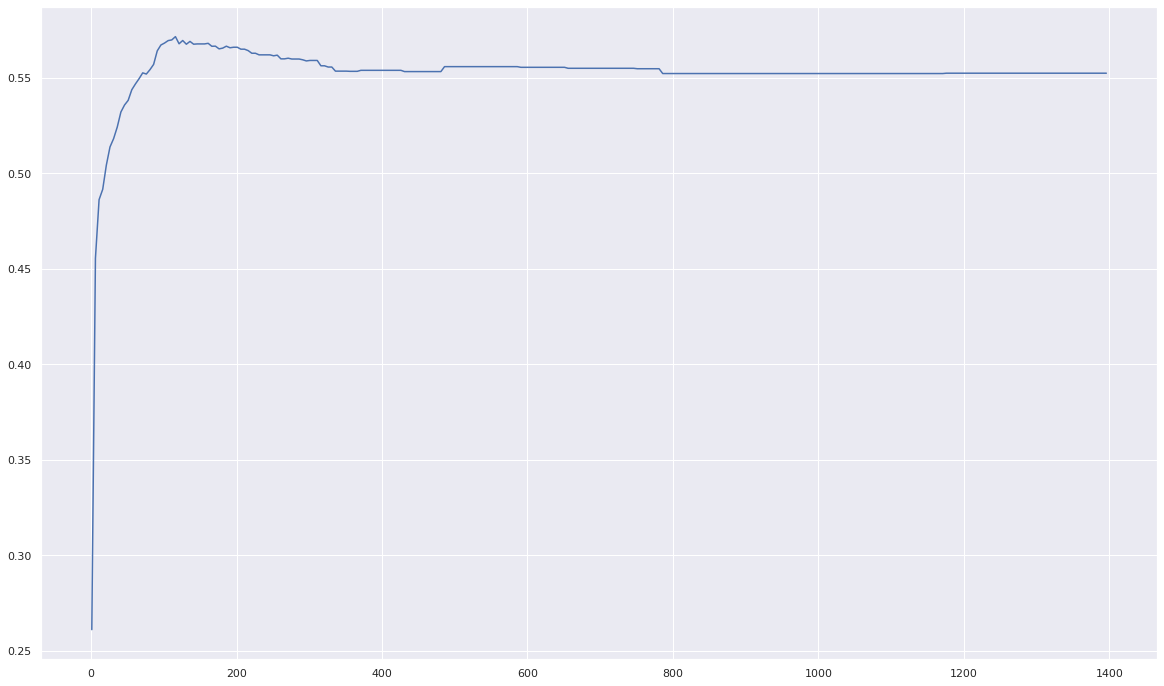

In [39]:
sns.set(rc={'figure.figsize':(20,12)})
sns.lineplot(data=f1_results_unigram_bigram_supervised)

In [40]:
# Getting the optimal number of features which will result in best mean cross validation F1-score from the dictionary

best_no_of_features= max(f1_results_unigram_bigram_supervised, key=f1_results_unigram_bigram_supervised.get)
best_no_of_features

116

In [41]:
# Extracting the optimal number of features into a dataframe for training

chi2_columns = chi2_df_sorted.columns[:best_no_of_features]
scaled_train_supervised_unigram_bigram_df_chi_square = train_supervised_unigram_bigram_chi_square_df[chi2_columns]
scaled_test_supervised_unigram_bigram_df_chi_square = test_supervised_unigram_bigram_chi_square_df[chi2_columns]

In [42]:
X_train = scaled_train_supervised_unigram_bigram_df_chi_square
X_test = scaled_test_supervised_unigram_bigram_df_chi_square

clf = AdaBoostClassifier(random_state=0).fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
print('Train Accuracy: ' + '{:.2%}'.format(accuracy_score(y_train, y_train_pred)))

y_test_pred = clf.predict(X_test)
print('Test Accuracy: ' + '{:.2%}'.format(accuracy_score(y_test, y_test_pred)))
print('Test F1 Score: ' + '{:.2%}'.format(f1_score(y_test, y_test_pred, average='weighted')))

## Cross Validation
cross_val_accuracy_scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=10, n_jobs=-1)   
print("Mean Cross Val Accuracy: " + '{:.2%}'.format(cross_val_accuracy_scores.mean()))
    
cross_val_f1_scores = cross_val_score(clf, X_train, y_train, scoring='f1_weighted', cv=10, n_jobs=-1)
print("Mean Cross Val F1 Score: " + '{:.2%}'.format(cross_val_f1_scores.mean()))

testing_matthew_coeff = matthews_corrcoef(y_test, y_test_pred)
print("Testing Matthew's coefficient:", round(testing_matthew_coeff,3))

Train Accuracy: 60.74%
Test Accuracy: 66.74%
Test F1 Score: 64.64%
Mean Cross Val Accuracy: 59.25%
Mean Cross Val F1 Score: 57.35%
Testing Matthew's coefficient: 0.322
